# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

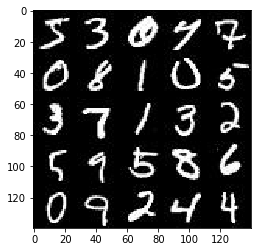

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

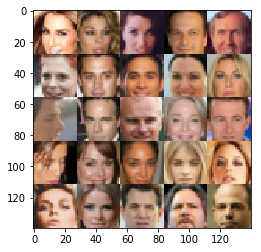

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, (), name='learning_rate')
    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28*28*dim
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 14*14*128

        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7*7*256

        # Flatten it
        flat = tf.reshape(x2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):    
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7*7*256 now
      
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14*14*128 now
    
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28*28*out_channel_dim now
        
        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print(data_shape)
    
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    print_every = 10
    show_every = 100
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_i = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_i += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}... Batch {}".format(epoch_i+1, epoch_count, batch_i),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, 32, input_z, data_shape[-1], data_image_mode)
        
        print("\nFinally:")
        show_generator_output(sess, 32, input_z, data_shape[-1], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2... Batch 10 Discriminator Loss: 6.7688... Generator Loss: 1.6046
Epoch 1/2... Batch 20 Discriminator Loss: 6.0980... Generator Loss: 0.2012
Epoch 1/2... Batch 30 Discriminator Loss: 1.9009... Generator Loss: 0.6601
Epoch 1/2... Batch 40 Discriminator Loss: 1.3744... Generator Loss: 2.5970
Epoch 1/2... Batch 50 Discriminator Loss: 1.9033... Generator Loss: 8.2710
Epoch 1/2... Batch 60 Discriminator Loss: 0.1310... Generator Loss: 5.0154
Epoch 1/2... Batch 70 Discriminator Loss: 11.2762... Generator Loss: 15.9964
Epoch 1/2... Batch 80 Discriminator Loss: 0.3539... Generator Loss: 2.9422
Epoch 1/2... Batch 90 Discriminator Loss: 0.0725... Generator Loss: 4.2243
Epoch 1/2... Batch 100 Discriminator Loss: 0.3433... Generator Loss: 4.9882


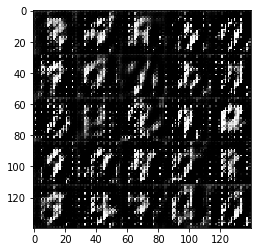

Epoch 1/2... Batch 110 Discriminator Loss: 1.4605... Generator Loss: 2.5755
Epoch 1/2... Batch 120 Discriminator Loss: 0.7027... Generator Loss: 5.4182
Epoch 1/2... Batch 130 Discriminator Loss: 0.4788... Generator Loss: 4.3325
Epoch 1/2... Batch 140 Discriminator Loss: 0.0188... Generator Loss: 5.4333
Epoch 1/2... Batch 150 Discriminator Loss: 0.0161... Generator Loss: 5.2852
Epoch 1/2... Batch 160 Discriminator Loss: 0.1598... Generator Loss: 2.9858
Epoch 1/2... Batch 170 Discriminator Loss: 0.0053... Generator Loss: 6.9878
Epoch 1/2... Batch 180 Discriminator Loss: 1.6777... Generator Loss: 16.1498
Epoch 1/2... Batch 190 Discriminator Loss: 0.0893... Generator Loss: 4.8474
Epoch 1/2... Batch 200 Discriminator Loss: 7.5958... Generator Loss: 0.0095


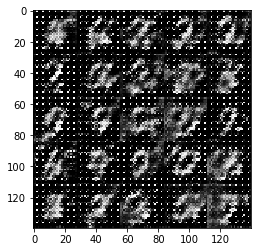

Epoch 1/2... Batch 210 Discriminator Loss: 0.0224... Generator Loss: 7.3778
Epoch 1/2... Batch 220 Discriminator Loss: 0.2719... Generator Loss: 2.6014
Epoch 1/2... Batch 230 Discriminator Loss: 0.3533... Generator Loss: 5.5352
Epoch 1/2... Batch 240 Discriminator Loss: 0.8765... Generator Loss: 3.0216
Epoch 1/2... Batch 250 Discriminator Loss: 0.3628... Generator Loss: 5.3872
Epoch 1/2... Batch 260 Discriminator Loss: 6.7243... Generator Loss: 20.0289
Epoch 1/2... Batch 270 Discriminator Loss: 0.2990... Generator Loss: 5.2752
Epoch 1/2... Batch 280 Discriminator Loss: 0.7868... Generator Loss: 6.9965
Epoch 1/2... Batch 290 Discriminator Loss: 0.1687... Generator Loss: 6.1958
Epoch 1/2... Batch 300 Discriminator Loss: 0.5087... Generator Loss: 3.4646


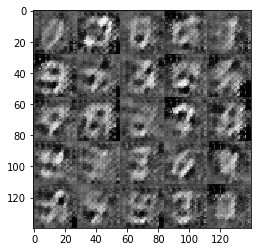

Epoch 1/2... Batch 310 Discriminator Loss: 2.3446... Generator Loss: 0.7680
Epoch 1/2... Batch 320 Discriminator Loss: 0.9476... Generator Loss: 6.9333
Epoch 1/2... Batch 330 Discriminator Loss: 6.6985... Generator Loss: 9.0832
Epoch 1/2... Batch 340 Discriminator Loss: 4.0415... Generator Loss: 7.8641
Epoch 1/2... Batch 350 Discriminator Loss: 1.2293... Generator Loss: 1.1875
Epoch 1/2... Batch 360 Discriminator Loss: 1.5067... Generator Loss: 0.5707
Epoch 1/2... Batch 370 Discriminator Loss: 1.3457... Generator Loss: 4.5574
Epoch 1/2... Batch 380 Discriminator Loss: 0.7716... Generator Loss: 4.3562
Epoch 1/2... Batch 390 Discriminator Loss: 1.9051... Generator Loss: 0.3111
Epoch 1/2... Batch 400 Discriminator Loss: 0.9317... Generator Loss: 0.7378


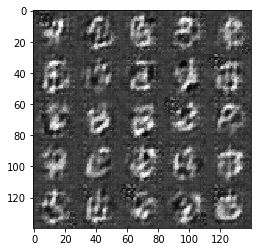

Epoch 1/2... Batch 410 Discriminator Loss: 1.4551... Generator Loss: 5.1251
Epoch 1/2... Batch 420 Discriminator Loss: 2.1272... Generator Loss: 0.2477
Epoch 1/2... Batch 430 Discriminator Loss: 1.0934... Generator Loss: 4.2966
Epoch 1/2... Batch 440 Discriminator Loss: 0.4641... Generator Loss: 1.8568
Epoch 1/2... Batch 450 Discriminator Loss: 0.3550... Generator Loss: 2.0232
Epoch 1/2... Batch 460 Discriminator Loss: 0.2898... Generator Loss: 1.8231
Epoch 2/2... Batch 2 Discriminator Loss: 1.1500... Generator Loss: 0.7402
Epoch 2/2... Batch 12 Discriminator Loss: 0.2786... Generator Loss: 2.2334
Epoch 2/2... Batch 22 Discriminator Loss: 6.4717... Generator Loss: 0.0112
Epoch 2/2... Batch 32 Discriminator Loss: 1.4570... Generator Loss: 4.7517


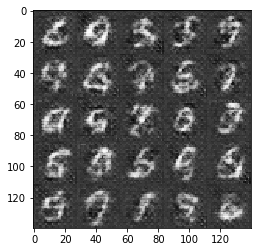

Epoch 2/2... Batch 42 Discriminator Loss: 0.3144... Generator Loss: 2.4234
Epoch 2/2... Batch 52 Discriminator Loss: 0.3063... Generator Loss: 1.9486
Epoch 2/2... Batch 62 Discriminator Loss: 0.2971... Generator Loss: 1.9139
Epoch 2/2... Batch 72 Discriminator Loss: 0.2215... Generator Loss: 2.4528
Epoch 2/2... Batch 82 Discriminator Loss: 0.3536... Generator Loss: 1.5858
Epoch 2/2... Batch 92 Discriminator Loss: 0.2250... Generator Loss: 2.2478
Epoch 2/2... Batch 102 Discriminator Loss: 0.3521... Generator Loss: 1.7804
Epoch 2/2... Batch 112 Discriminator Loss: 0.1828... Generator Loss: 2.5599
Epoch 2/2... Batch 122 Discriminator Loss: 0.5263... Generator Loss: 1.1904
Epoch 2/2... Batch 132 Discriminator Loss: 0.8666... Generator Loss: 1.3659


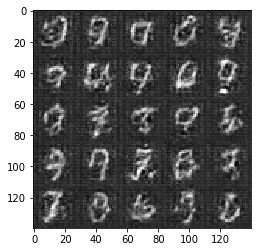

Epoch 2/2... Batch 142 Discriminator Loss: 1.8409... Generator Loss: 0.2950
Epoch 2/2... Batch 152 Discriminator Loss: 0.4985... Generator Loss: 1.4077
Epoch 2/2... Batch 162 Discriminator Loss: 0.8827... Generator Loss: 2.3295
Epoch 2/2... Batch 172 Discriminator Loss: 0.9757... Generator Loss: 0.6357
Epoch 2/2... Batch 182 Discriminator Loss: 0.3786... Generator Loss: 1.7120
Epoch 2/2... Batch 192 Discriminator Loss: 0.4444... Generator Loss: 1.3846
Epoch 2/2... Batch 202 Discriminator Loss: 0.3119... Generator Loss: 1.9116
Epoch 2/2... Batch 212 Discriminator Loss: 0.2975... Generator Loss: 1.6727
Epoch 2/2... Batch 222 Discriminator Loss: 0.1369... Generator Loss: 2.7202
Epoch 2/2... Batch 232 Discriminator Loss: 0.2242... Generator Loss: 2.0781


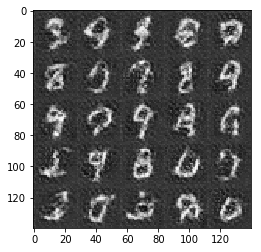

Epoch 2/2... Batch 242 Discriminator Loss: 2.6635... Generator Loss: 0.1239
Epoch 2/2... Batch 252 Discriminator Loss: 0.8773... Generator Loss: 0.8237
Epoch 2/2... Batch 262 Discriminator Loss: 1.5817... Generator Loss: 0.3329
Epoch 2/2... Batch 272 Discriminator Loss: 0.6857... Generator Loss: 2.7011
Epoch 2/2... Batch 282 Discriminator Loss: 1.0072... Generator Loss: 0.6845
Epoch 2/2... Batch 292 Discriminator Loss: 0.5861... Generator Loss: 1.1119
Epoch 2/2... Batch 302 Discriminator Loss: 0.3852... Generator Loss: 1.6334
Epoch 2/2... Batch 312 Discriminator Loss: 0.4522... Generator Loss: 2.3925
Epoch 2/2... Batch 322 Discriminator Loss: 0.8519... Generator Loss: 1.0061
Epoch 2/2... Batch 332 Discriminator Loss: 0.4984... Generator Loss: 2.0589


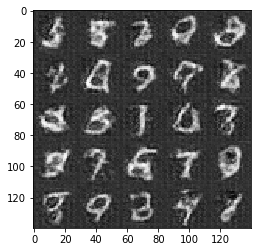

Epoch 2/2... Batch 342 Discriminator Loss: 0.4615... Generator Loss: 1.7901
Epoch 2/2... Batch 352 Discriminator Loss: 0.3200... Generator Loss: 1.7930
Epoch 2/2... Batch 362 Discriminator Loss: 0.2999... Generator Loss: 1.6308
Epoch 2/2... Batch 372 Discriminator Loss: 0.4482... Generator Loss: 1.2932
Epoch 2/2... Batch 382 Discriminator Loss: 0.2940... Generator Loss: 1.7352
Epoch 2/2... Batch 392 Discriminator Loss: 0.1788... Generator Loss: 2.2052
Epoch 2/2... Batch 402 Discriminator Loss: 0.0424... Generator Loss: 4.3037
Epoch 2/2... Batch 412 Discriminator Loss: 1.0231... Generator Loss: 3.0875
Epoch 2/2... Batch 422 Discriminator Loss: 1.4630... Generator Loss: 0.4197
Epoch 2/2... Batch 432 Discriminator Loss: 1.3117... Generator Loss: 2.9557


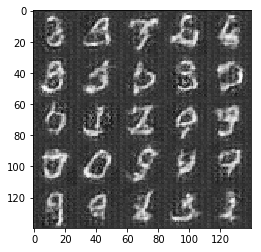

Epoch 2/2... Batch 442 Discriminator Loss: 2.0737... Generator Loss: 0.1955
Epoch 2/2... Batch 452 Discriminator Loss: 0.6009... Generator Loss: 3.5765
Epoch 2/2... Batch 462 Discriminator Loss: 0.7560... Generator Loss: 1.0806

Finally:


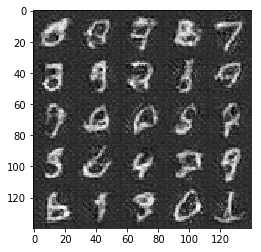

In [31]:
batch_size = 128
z_dim = 100
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/1... Batch 10 Discriminator Loss: 4.7319... Generator Loss: 8.3353
Epoch 1/1... Batch 20 Discriminator Loss: 0.6225... Generator Loss: 4.9015
Epoch 1/1... Batch 30 Discriminator Loss: 1.4099... Generator Loss: 2.3343
Epoch 1/1... Batch 40 Discriminator Loss: 0.3579... Generator Loss: 5.4080
Epoch 1/1... Batch 50 Discriminator Loss: 0.3362... Generator Loss: 2.5511
Epoch 1/1... Batch 60 Discriminator Loss: 6.6047... Generator Loss: 0.0160
Epoch 1/1... Batch 70 Discriminator Loss: 0.0280... Generator Loss: 7.9632
Epoch 1/1... Batch 80 Discriminator Loss: 0.0963... Generator Loss: 3.6234
Epoch 1/1... Batch 90 Discriminator Loss: 0.8451... Generator Loss: 1.2692
Epoch 1/1... Batch 100 Discriminator Loss: 0.9234... Generator Loss: 5.7258


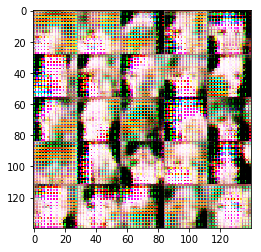

Epoch 1/1... Batch 110 Discriminator Loss: 7.1400... Generator Loss: 0.0266
Epoch 1/1... Batch 120 Discriminator Loss: 0.3096... Generator Loss: 3.3792
Epoch 1/1... Batch 130 Discriminator Loss: 0.0286... Generator Loss: 11.9952
Epoch 1/1... Batch 140 Discriminator Loss: 0.0564... Generator Loss: 4.8014
Epoch 1/1... Batch 150 Discriminator Loss: 0.0619... Generator Loss: 4.9824
Epoch 1/1... Batch 160 Discriminator Loss: 0.0093... Generator Loss: 7.1318
Epoch 1/1... Batch 170 Discriminator Loss: 0.0018... Generator Loss: 14.4600
Epoch 1/1... Batch 180 Discriminator Loss: 0.0498... Generator Loss: 4.2609
Epoch 1/1... Batch 190 Discriminator Loss: 0.0035... Generator Loss: 8.1962
Epoch 1/1... Batch 200 Discriminator Loss: 0.0009... Generator Loss: 21.7276


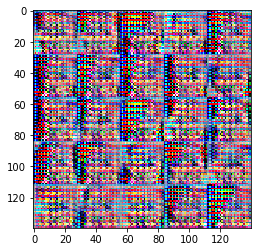

Epoch 1/1... Batch 210 Discriminator Loss: 0.0198... Generator Loss: 5.8245
Epoch 1/1... Batch 220 Discriminator Loss: 0.0113... Generator Loss: 5.7173
Epoch 1/1... Batch 230 Discriminator Loss: 0.0019... Generator Loss: 8.3972
Epoch 1/1... Batch 240 Discriminator Loss: 0.0244... Generator Loss: 6.4583
Epoch 1/1... Batch 250 Discriminator Loss: 0.0173... Generator Loss: 5.0792
Epoch 1/1... Batch 260 Discriminator Loss: 0.0101... Generator Loss: 5.8829
Epoch 1/1... Batch 270 Discriminator Loss: 0.0830... Generator Loss: 3.4044
Epoch 1/1... Batch 280 Discriminator Loss: 0.0320... Generator Loss: 4.5495
Epoch 1/1... Batch 290 Discriminator Loss: 0.0002... Generator Loss: 17.4479
Epoch 1/1... Batch 300 Discriminator Loss: 0.0003... Generator Loss: 14.6163


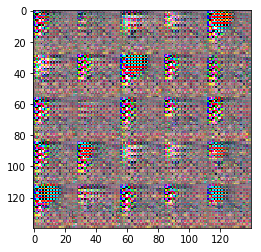

Epoch 1/1... Batch 310 Discriminator Loss: 0.0001... Generator Loss: 14.2662
Epoch 1/1... Batch 320 Discriminator Loss: 2.5019... Generator Loss: 0.8085
Epoch 1/1... Batch 330 Discriminator Loss: 2.0563... Generator Loss: 8.9232
Epoch 1/1... Batch 340 Discriminator Loss: 0.1336... Generator Loss: 9.6522
Epoch 1/1... Batch 350 Discriminator Loss: 0.0822... Generator Loss: 17.4910
Epoch 1/1... Batch 360 Discriminator Loss: 2.5556... Generator Loss: 2.1466
Epoch 1/1... Batch 370 Discriminator Loss: 3.9021... Generator Loss: 8.7238
Epoch 1/1... Batch 380 Discriminator Loss: 0.1351... Generator Loss: 6.9561
Epoch 1/1... Batch 390 Discriminator Loss: 1.4550... Generator Loss: 12.5248
Epoch 1/1... Batch 400 Discriminator Loss: 0.7424... Generator Loss: 6.7326


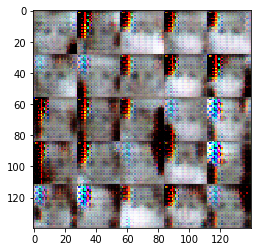

Epoch 1/1... Batch 410 Discriminator Loss: 0.5018... Generator Loss: 6.3589
Epoch 1/1... Batch 420 Discriminator Loss: 0.2194... Generator Loss: 5.7020
Epoch 1/1... Batch 430 Discriminator Loss: 1.0382... Generator Loss: 2.2145
Epoch 1/1... Batch 440 Discriminator Loss: 0.0225... Generator Loss: 13.0841
Epoch 1/1... Batch 450 Discriminator Loss: 0.0749... Generator Loss: 9.6116
Epoch 1/1... Batch 460 Discriminator Loss: 0.0153... Generator Loss: 12.1780
Epoch 1/1... Batch 470 Discriminator Loss: 0.0110... Generator Loss: 11.4293
Epoch 1/1... Batch 480 Discriminator Loss: 0.2377... Generator Loss: 8.0681
Epoch 1/1... Batch 490 Discriminator Loss: 0.0316... Generator Loss: 8.2889
Epoch 1/1... Batch 500 Discriminator Loss: 0.0267... Generator Loss: 10.0312


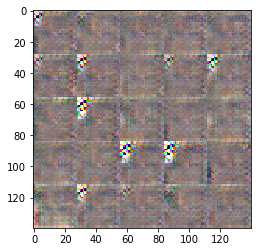

Epoch 1/1... Batch 510 Discriminator Loss: 0.0337... Generator Loss: 17.8767
Epoch 1/1... Batch 520 Discriminator Loss: 6.5573... Generator Loss: 16.3364
Epoch 1/1... Batch 530 Discriminator Loss: 2.1572... Generator Loss: 2.0761
Epoch 1/1... Batch 540 Discriminator Loss: 3.2532... Generator Loss: 0.2902
Epoch 1/1... Batch 550 Discriminator Loss: 3.5741... Generator Loss: 7.3568
Epoch 1/1... Batch 560 Discriminator Loss: 0.8015... Generator Loss: 2.3917
Epoch 1/1... Batch 570 Discriminator Loss: 3.3752... Generator Loss: 0.2570
Epoch 1/1... Batch 580 Discriminator Loss: 3.5834... Generator Loss: 0.1929
Epoch 1/1... Batch 590 Discriminator Loss: 3.5300... Generator Loss: 0.1251
Epoch 1/1... Batch 600 Discriminator Loss: 2.5972... Generator Loss: 4.3742


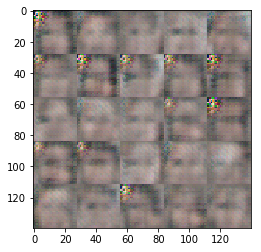

Epoch 1/1... Batch 610 Discriminator Loss: 2.1849... Generator Loss: 0.9336
Epoch 1/1... Batch 620 Discriminator Loss: 0.7789... Generator Loss: 1.3341
Epoch 1/1... Batch 630 Discriminator Loss: 2.3585... Generator Loss: 2.8530
Epoch 1/1... Batch 640 Discriminator Loss: 1.5936... Generator Loss: 1.8743
Epoch 1/1... Batch 650 Discriminator Loss: 1.2531... Generator Loss: 2.6923
Epoch 1/1... Batch 660 Discriminator Loss: 1.8764... Generator Loss: 0.5420
Epoch 1/1... Batch 670 Discriminator Loss: 1.2322... Generator Loss: 1.3544
Epoch 1/1... Batch 680 Discriminator Loss: 1.7198... Generator Loss: 0.3825
Epoch 1/1... Batch 690 Discriminator Loss: 0.9201... Generator Loss: 1.3719
Epoch 1/1... Batch 700 Discriminator Loss: 1.3805... Generator Loss: 0.5321


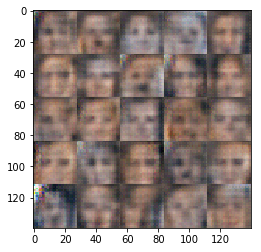

Epoch 1/1... Batch 710 Discriminator Loss: 0.7232... Generator Loss: 2.0015
Epoch 1/1... Batch 720 Discriminator Loss: 1.8876... Generator Loss: 1.8297
Epoch 1/1... Batch 730 Discriminator Loss: 0.9650... Generator Loss: 1.5203
Epoch 1/1... Batch 740 Discriminator Loss: 2.0112... Generator Loss: 0.3573
Epoch 1/1... Batch 750 Discriminator Loss: 1.1961... Generator Loss: 1.0247
Epoch 1/1... Batch 760 Discriminator Loss: 1.4819... Generator Loss: 1.9646
Epoch 1/1... Batch 770 Discriminator Loss: 1.1748... Generator Loss: 1.5246
Epoch 1/1... Batch 780 Discriminator Loss: 1.1588... Generator Loss: 0.9687
Epoch 1/1... Batch 790 Discriminator Loss: 0.9704... Generator Loss: 1.0860
Epoch 1/1... Batch 800 Discriminator Loss: 1.4853... Generator Loss: 1.8175


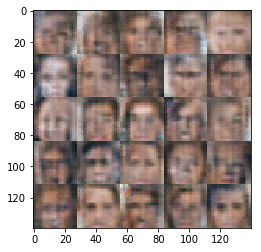

Epoch 1/1... Batch 810 Discriminator Loss: 1.1249... Generator Loss: 1.0659
Epoch 1/1... Batch 820 Discriminator Loss: 0.9413... Generator Loss: 1.5015
Epoch 1/1... Batch 830 Discriminator Loss: 0.8771... Generator Loss: 0.9610
Epoch 1/1... Batch 840 Discriminator Loss: 0.6721... Generator Loss: 2.0048
Epoch 1/1... Batch 850 Discriminator Loss: 1.6720... Generator Loss: 1.4217
Epoch 1/1... Batch 860 Discriminator Loss: 1.1565... Generator Loss: 1.3512
Epoch 1/1... Batch 870 Discriminator Loss: 1.2328... Generator Loss: 1.1642
Epoch 1/1... Batch 880 Discriminator Loss: 1.6560... Generator Loss: 0.3881
Epoch 1/1... Batch 890 Discriminator Loss: 1.8199... Generator Loss: 0.3042
Epoch 1/1... Batch 900 Discriminator Loss: 2.1323... Generator Loss: 0.2150


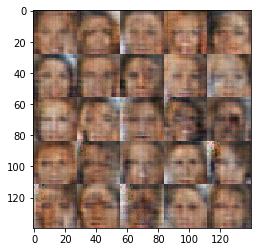

Epoch 1/1... Batch 910 Discriminator Loss: 1.2135... Generator Loss: 2.2679
Epoch 1/1... Batch 920 Discriminator Loss: 0.9739... Generator Loss: 1.1264
Epoch 1/1... Batch 930 Discriminator Loss: 2.0651... Generator Loss: 0.2230
Epoch 1/1... Batch 940 Discriminator Loss: 1.0269... Generator Loss: 0.7812
Epoch 1/1... Batch 950 Discriminator Loss: 2.9454... Generator Loss: 0.1285
Epoch 1/1... Batch 960 Discriminator Loss: 1.6023... Generator Loss: 1.3891
Epoch 1/1... Batch 970 Discriminator Loss: 1.2521... Generator Loss: 0.5458
Epoch 1/1... Batch 980 Discriminator Loss: 1.3487... Generator Loss: 1.3654
Epoch 1/1... Batch 990 Discriminator Loss: 1.3079... Generator Loss: 0.4863
Epoch 1/1... Batch 1000 Discriminator Loss: 1.6184... Generator Loss: 0.8640


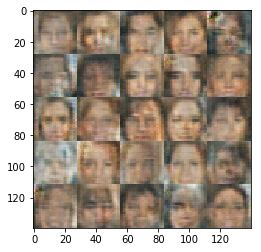

Epoch 1/1... Batch 1010 Discriminator Loss: 0.7746... Generator Loss: 1.6374
Epoch 1/1... Batch 1020 Discriminator Loss: 1.8064... Generator Loss: 1.6972
Epoch 1/1... Batch 1030 Discriminator Loss: 1.3320... Generator Loss: 0.8876
Epoch 1/1... Batch 1040 Discriminator Loss: 1.1664... Generator Loss: 1.1584
Epoch 1/1... Batch 1050 Discriminator Loss: 1.3632... Generator Loss: 0.4919
Epoch 1/1... Batch 1060 Discriminator Loss: 1.1145... Generator Loss: 1.0466
Epoch 1/1... Batch 1070 Discriminator Loss: 1.1868... Generator Loss: 1.1706
Epoch 1/1... Batch 1080 Discriminator Loss: 1.1543... Generator Loss: 1.1372
Epoch 1/1... Batch 1090 Discriminator Loss: 1.2298... Generator Loss: 2.1216
Epoch 1/1... Batch 1100 Discriminator Loss: 1.5705... Generator Loss: 2.4808


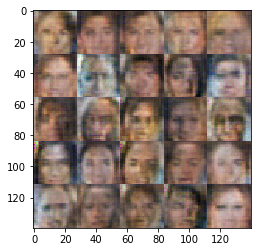

Epoch 1/1... Batch 1110 Discriminator Loss: 1.0952... Generator Loss: 0.9186
Epoch 1/1... Batch 1120 Discriminator Loss: 1.2633... Generator Loss: 1.3739
Epoch 1/1... Batch 1130 Discriminator Loss: 0.9294... Generator Loss: 2.0437
Epoch 1/1... Batch 1140 Discriminator Loss: 1.8086... Generator Loss: 0.3944
Epoch 1/1... Batch 1150 Discriminator Loss: 1.7940... Generator Loss: 2.6464
Epoch 1/1... Batch 1160 Discriminator Loss: 1.2646... Generator Loss: 1.3468
Epoch 1/1... Batch 1170 Discriminator Loss: 1.1776... Generator Loss: 1.4210
Epoch 1/1... Batch 1180 Discriminator Loss: 0.8661... Generator Loss: 1.8631
Epoch 1/1... Batch 1190 Discriminator Loss: 1.1253... Generator Loss: 0.8154
Epoch 1/1... Batch 1200 Discriminator Loss: 0.5546... Generator Loss: 1.5544


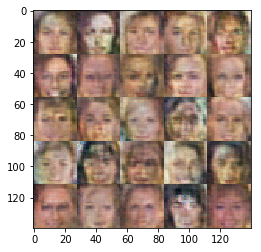

Epoch 1/1... Batch 1210 Discriminator Loss: 1.1555... Generator Loss: 0.6252
Epoch 1/1... Batch 1220 Discriminator Loss: 0.7262... Generator Loss: 1.2554
Epoch 1/1... Batch 1230 Discriminator Loss: 1.9731... Generator Loss: 0.3004
Epoch 1/1... Batch 1240 Discriminator Loss: 0.9819... Generator Loss: 1.2625
Epoch 1/1... Batch 1250 Discriminator Loss: 0.9599... Generator Loss: 1.0418
Epoch 1/1... Batch 1260 Discriminator Loss: 1.2230... Generator Loss: 0.6773
Epoch 1/1... Batch 1270 Discriminator Loss: 0.9745... Generator Loss: 0.9387
Epoch 1/1... Batch 1280 Discriminator Loss: 1.3669... Generator Loss: 0.4549
Epoch 1/1... Batch 1290 Discriminator Loss: 1.0456... Generator Loss: 0.9567
Epoch 1/1... Batch 1300 Discriminator Loss: 3.0985... Generator Loss: 3.2495


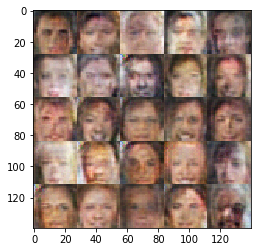

Epoch 1/1... Batch 1310 Discriminator Loss: 1.5116... Generator Loss: 1.3512
Epoch 1/1... Batch 1320 Discriminator Loss: 1.0140... Generator Loss: 1.2568
Epoch 1/1... Batch 1330 Discriminator Loss: 1.3798... Generator Loss: 1.4757
Epoch 1/1... Batch 1340 Discriminator Loss: 1.1832... Generator Loss: 2.1885
Epoch 1/1... Batch 1350 Discriminator Loss: 1.2264... Generator Loss: 1.6374
Epoch 1/1... Batch 1360 Discriminator Loss: 1.6347... Generator Loss: 0.3425
Epoch 1/1... Batch 1370 Discriminator Loss: 1.5154... Generator Loss: 2.3516
Epoch 1/1... Batch 1380 Discriminator Loss: 1.7250... Generator Loss: 1.0674
Epoch 1/1... Batch 1390 Discriminator Loss: 1.0448... Generator Loss: 0.7799
Epoch 1/1... Batch 1400 Discriminator Loss: 0.9956... Generator Loss: 1.4253


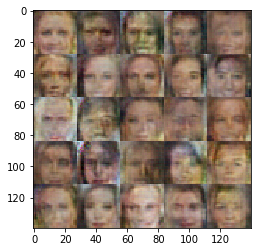

Epoch 1/1... Batch 1410 Discriminator Loss: 1.7024... Generator Loss: 2.4036
Epoch 1/1... Batch 1420 Discriminator Loss: 1.1233... Generator Loss: 1.0019
Epoch 1/1... Batch 1430 Discriminator Loss: 2.7062... Generator Loss: 0.1042
Epoch 1/1... Batch 1440 Discriminator Loss: 1.3200... Generator Loss: 1.8239
Epoch 1/1... Batch 1450 Discriminator Loss: 1.4396... Generator Loss: 1.2758
Epoch 1/1... Batch 1460 Discriminator Loss: 1.0424... Generator Loss: 0.7883
Epoch 1/1... Batch 1470 Discriminator Loss: 1.7550... Generator Loss: 0.7903
Epoch 1/1... Batch 1480 Discriminator Loss: 1.1698... Generator Loss: 1.0967
Epoch 1/1... Batch 1490 Discriminator Loss: 1.1042... Generator Loss: 1.7788
Epoch 1/1... Batch 1500 Discriminator Loss: 1.2349... Generator Loss: 0.6621


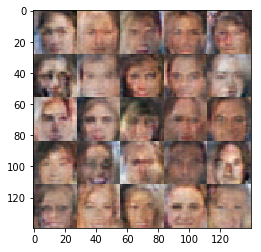

Epoch 1/1... Batch 1510 Discriminator Loss: 1.1747... Generator Loss: 0.7006
Epoch 1/1... Batch 1520 Discriminator Loss: 1.0933... Generator Loss: 0.7733
Epoch 1/1... Batch 1530 Discriminator Loss: 0.7813... Generator Loss: 1.2635
Epoch 1/1... Batch 1540 Discriminator Loss: 1.2700... Generator Loss: 1.0079
Epoch 1/1... Batch 1550 Discriminator Loss: 2.2895... Generator Loss: 3.3906
Epoch 1/1... Batch 1560 Discriminator Loss: 1.0086... Generator Loss: 1.6551
Epoch 1/1... Batch 1570 Discriminator Loss: 0.8253... Generator Loss: 1.2326
Epoch 1/1... Batch 1580 Discriminator Loss: 1.2139... Generator Loss: 0.8790

Finally:


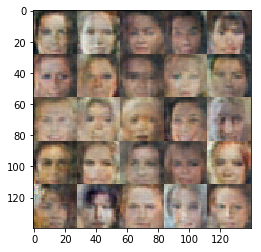

In [33]:
batch_size = 128
z_dim = 100
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.